<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>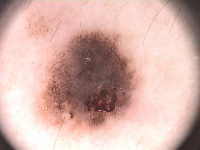</td><td>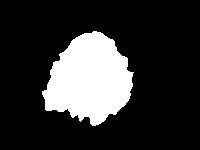</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2dataset/PH2Dataset'
import torch

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

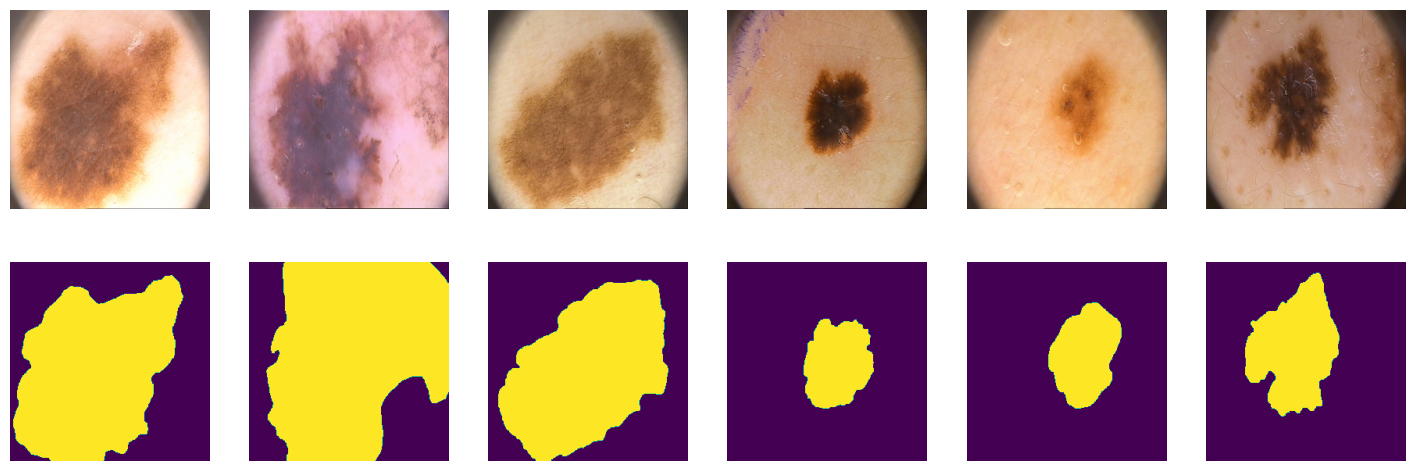

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'
device

device(type='cuda')

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

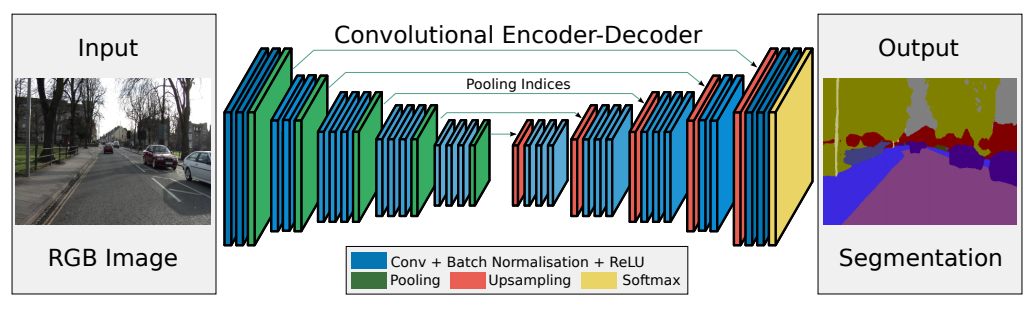

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True) # 32 -> 16
        
        self.bottle_neck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0),
            nn.BatchNorm2d(1024), 
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )                          
    
    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        size0 = e0.size()
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        size1 = e1.size()
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        size2 = e2.size()
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottle_neck_conv(e3)
        # decoder
        d1 = self.dec_conv1(self.upsample1(b, ind3, output_size=size2))
        d2 = self.dec_conv2(self.upsample2(d1, ind2, output_size=size1))
        d3 = self.dec_conv3(self.upsample3(d2, ind1, output_size=size0))
        d4 = self.dec_conv4(self.upsample4(d3, ind0))
        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [13]:
def bce_loss( y_pred, y_real):
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

In [14]:
SegNet()

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [15]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad(): 
        Y_pred = np.array([ model(X_batch.to(device)).to('cpu').numpy() for X_batch, _ in data])
    return 1/(1 + np.exp(-Y_pred)) > 0.5

In [16]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
        Y_pred = torch.sigmoid(Y_pred) > 0.5
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [17]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    
    train_losses = []
    val_losses = []
    val_iou = []
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 60], gamma=0.1)
    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) 
            # data to device

            # set parameter gradients to zero
            optimizer.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
             
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss.to('cpu').detach())

        # show intermediate results
        # testing mode
        model.eval()
        avg_loss_v = 0
        for X_batch_v, Y_batch_v in data_val:
            with torch.no_grad():
                X_batch_v = X_batch_v.to(device)
                Y_batch_v = Y_batch_v.to(device)
                Y_pred_v = model(X_batch_v)
                loss_v = loss_fn(Y_pred_v, Y_batch_v)
                avg_loss_v += loss_v / len(data_val)
        print('val loss: %f' % avg_loss_v)
        val_losses.append(avg_loss_v.to('cpu').detach())
        
        sore_val = score_model(model, iou_pytorch, data_val)
        print('val iou: %f' % sore_val)
        val_iou.append(sore_val)
        
        scheduler.step()
    return train_losses, val_losses, val_iou

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [18]:
model = SegNet().to(device)

In [19]:
max_epochs = 70
optim = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
bce_train_loss, bce_val_loss, bce_segnet_iou= train(model, optim, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.722999
val loss: inf
val iou: 0.000000
* Epoch 2/70
loss: 0.690846
val loss: inf
val iou: 0.016000
* Epoch 3/70
loss: 0.658046
val loss: inf
val iou: 0.026000
* Epoch 4/70
loss: 0.617621
val loss: inf
val iou: 0.064000
* Epoch 5/70
loss: 0.608271
val loss: inf
val iou: 0.110000
* Epoch 6/70
loss: 0.527941
val loss: inf
val iou: 0.150000
* Epoch 7/70
loss: 0.508101
val loss: inf
val iou: 0.148000
* Epoch 8/70
loss: 0.488099
val loss: inf
val iou: 0.088000
* Epoch 9/70
loss: 0.464511
val loss: 0.879963
val iou: 0.088000
* Epoch 10/70
loss: 0.434768
val loss: 0.958337
val iou: 0.088000
* Epoch 11/70
loss: 0.422937
val loss: 1.051966
val iou: 0.084000
* Epoch 12/70
loss: 0.412662
val loss: 0.967920
val iou: 0.092000
* Epoch 13/70
loss: 0.407307
val loss: 0.839601
val iou: 0.100000
* Epoch 14/70
loss: 0.398080
val loss: 1.196008
val iou: 0.086000
* Epoch 15/70
loss: 0.398146
val loss: 1.453588
val iou: 0.084000
* Epoch 16/70
loss: 0.375531
val loss: 1.347686
val iou: 0.

In [20]:
bce_tr = score_model(model, iou_pytorch, data_tr)
bce_val = score_model(model, iou_pytorch, data_val)
bce_segnet_ts = score_model(model, iou_pytorch, data_ts)
print(f'Метрика iou bce segnet, train: {bce_tr}, val: {bce_val}, test: {bce_segnet_ts}')

Метрика iou bce segnet, train: 0.7419999986886978, val: 0.7240000069141388, test: 0.6899999678134918


In [21]:
def test_images(model):
    test_pred = predict(model, data_ts).reshape(50, 256, 256)
    test_true = np.array([Y_batch.numpy() for _, Y_batch in data_ts], dtype='float32').reshape(50, 256, 256)
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.title('true_image')
        plt.imshow(test_true[i])

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.title('predicted_image')
        plt.imshow(test_pred[i])
    plt.show();

In [22]:
def plot_loss(train_loss, val_loss, name, epochs=70):
    '''Из за большого временного шага (который уменьшается постепенно при помощи schedulera) на валидационной выборке на первых эпохах 
    большие значения лосса, поэтому я подрезал график для наглядности'''
    epochs = np.arange(1, max_epochs+1, 1)
    plt.style. use('bmh')
    plt.figure(figsize = (16, 9))
    plt.ylim([0,1])
    plt.xlim([0,max_epochs])
    plt.plot(epochs, train_loss, label=f'loss_{name}_train' )
    plt.plot(epochs, val_loss, label=f'loss_{name}_val' )
    plt.legend()


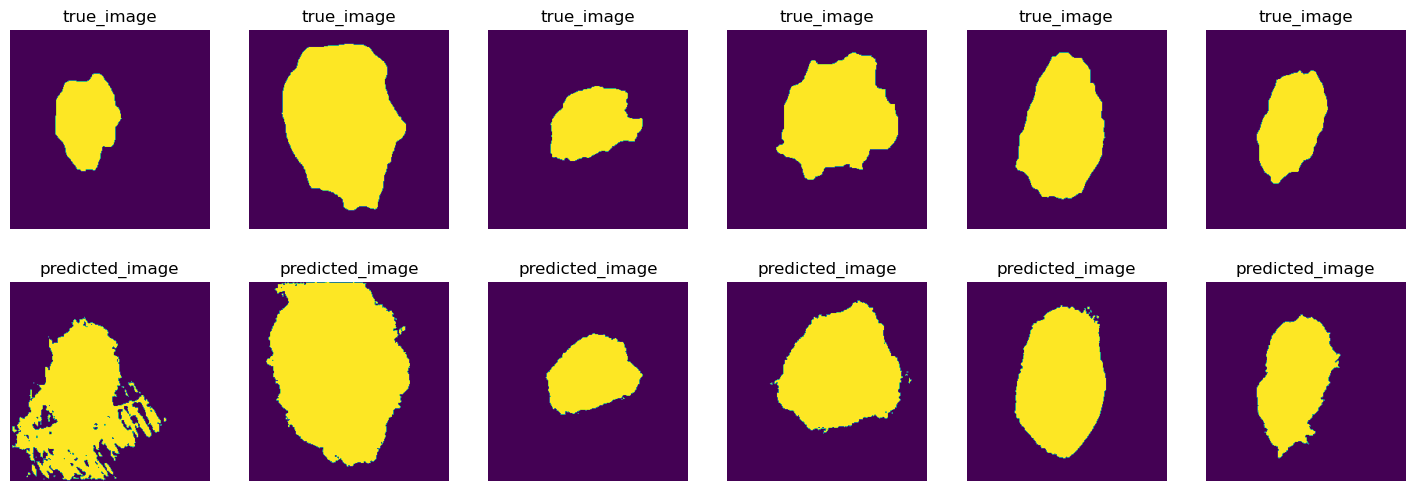

In [23]:
test_images(model)

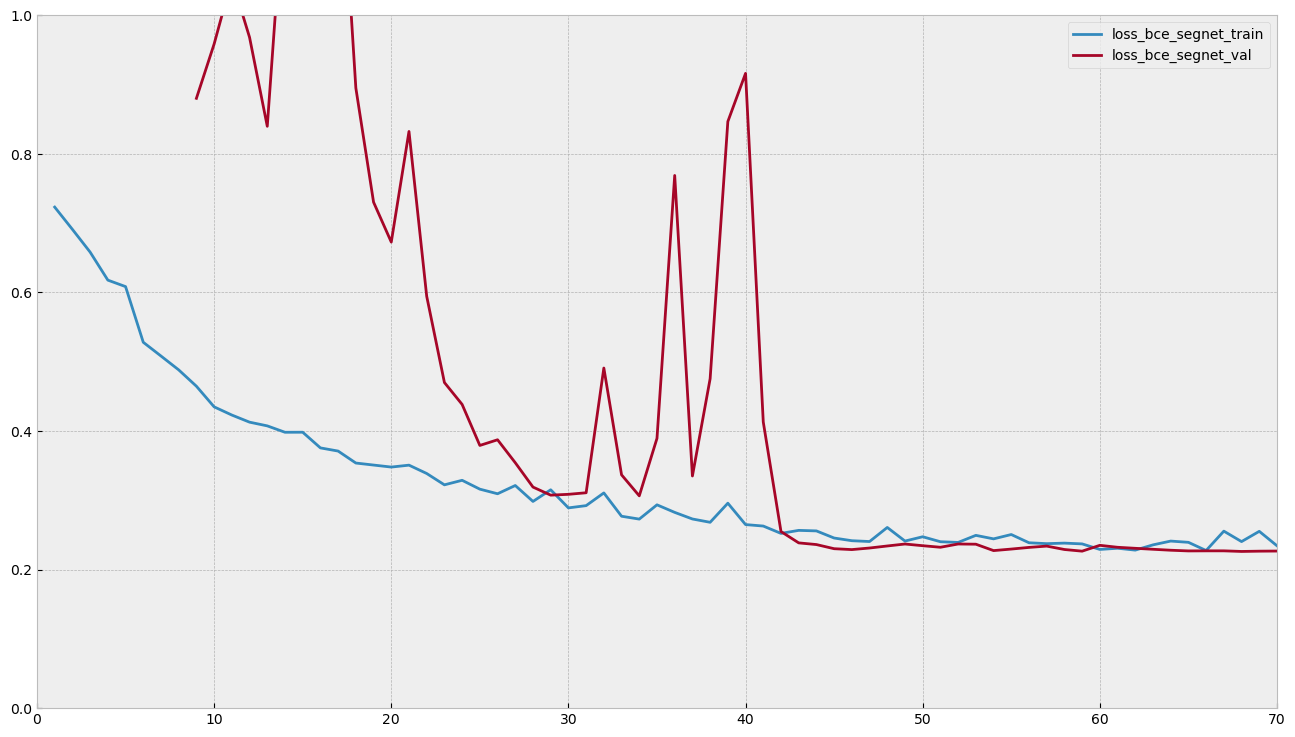

In [24]:
plot_loss(train_loss = bce_train_loss, val_loss = bce_val_loss, name = 'bce_segnet')

Ответьте себе на вопрос: не переобучается ли моя модель?

Модель немного переобучается, т.к. выборка изображений крайне мала, что выражается отличием метрики iou на тренировочных и тестовых данных, однако ввиду того что я ввел регуляризацию (weight_decay) loss на валидационных данных не увеличивается с увеличением количества эпох (на графике видно, что валидационный и тренировочный лоссы сходится к определенному значению). Можно сделать вывод, что благодаря регуляризации модели основых негативных последствий переобучения удалось избежать.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_pred, y_real):
    
    y_pred = torch.sigmoid(y_pred).view(-1)  
    y_real = y_real.view(-1)
    SMOOTH = 1e-8
    intersection = (y_pred * y_real).sum()  
    union = (y_pred + y_real).sum()        
    
    dice = 1 - ((2 * intersection + SMOOTH )/ (union + SMOOTH)) #/ (256 * 256)  
    
    return dice

Проводим тестирование:

In [26]:
model_dice = SegNet().to(device)
max_epochs = 70
optimizer = torch.optim.AdamW(model_dice.parameters(), lr=0.05, weight_decay=0.05)
dice_train_loss, dice_val_loss, dice_segnet_iou = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.584502
val loss: 1.000000
val iou: 0.000000
* Epoch 2/70
loss: 0.528502
val loss: 1.000000
val iou: 0.000000
* Epoch 3/70
loss: 0.442775
val loss: 1.000000
val iou: 0.000000
* Epoch 4/70
loss: 0.419370
val loss: 0.962317
val iou: 0.000000
* Epoch 5/70
loss: 0.407193
val loss: 0.647672
val iou: 0.024000
* Epoch 6/70
loss: 0.383388
val loss: 0.388040
val iou: 0.102000
* Epoch 7/70
loss: 0.375145
val loss: 0.361969
val iou: 0.134000
* Epoch 8/70
loss: 0.357595
val loss: 0.467195
val iou: 0.090000
* Epoch 9/70
loss: 0.331309
val loss: 0.432101
val iou: 0.136000
* Epoch 10/70
loss: 0.323768
val loss: 0.436568
val iou: 0.112000
* Epoch 11/70
loss: 0.294812
val loss: 0.450449
val iou: 0.112000
* Epoch 12/70
loss: 0.270723
val loss: 0.425499
val iou: 0.130000
* Epoch 13/70
loss: 0.252007
val loss: 0.476818
val iou: 0.084000
* Epoch 14/70
loss: 0.235531
val loss: 0.488714
val iou: 0.086000
* Epoch 15/70
loss: 0.232448
val loss: 0.507554
val iou: 0.080000
* Epoch 16/70
loss:

In [27]:
dice_tr = score_model(model_dice, iou_pytorch, data_tr)
dice_val = score_model(model_dice, iou_pytorch, data_val)
dice_segnet_ts = score_model(model_dice, iou_pytorch, data_ts)
print(f'Метрика iou, loss dice segnet, train: {dice_tr}, val: {dice_val}, test: {dice_segnet_ts}')

Метрика iou, loss dice segnet, train: 0.7220000177621841, val: 0.7119999825954437, test: 0.6599999964237213


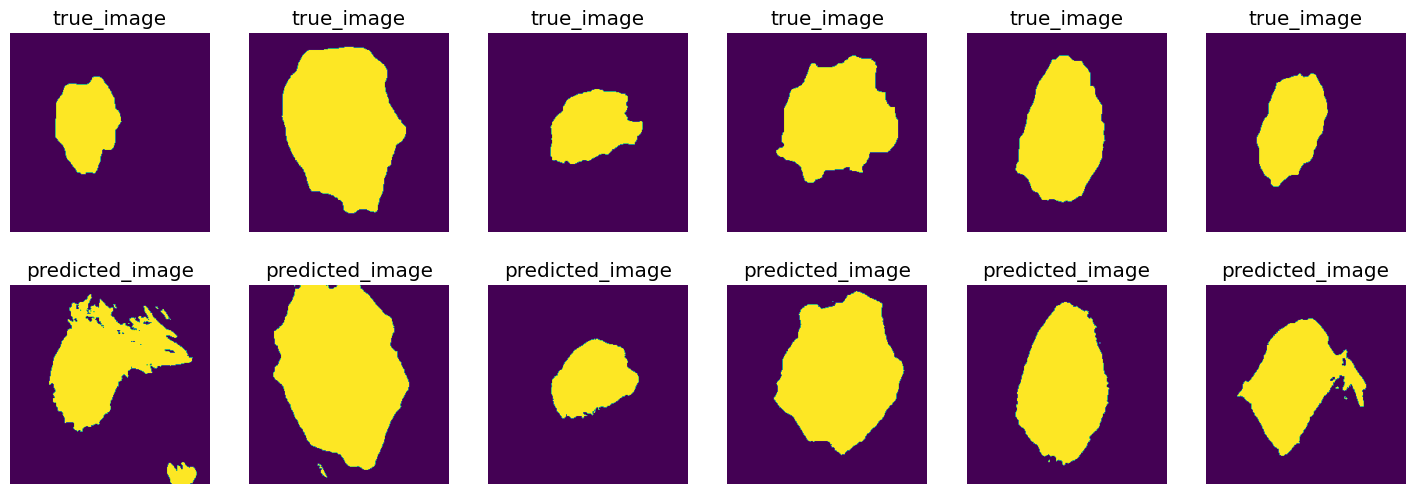

In [28]:
test_images(model_dice)

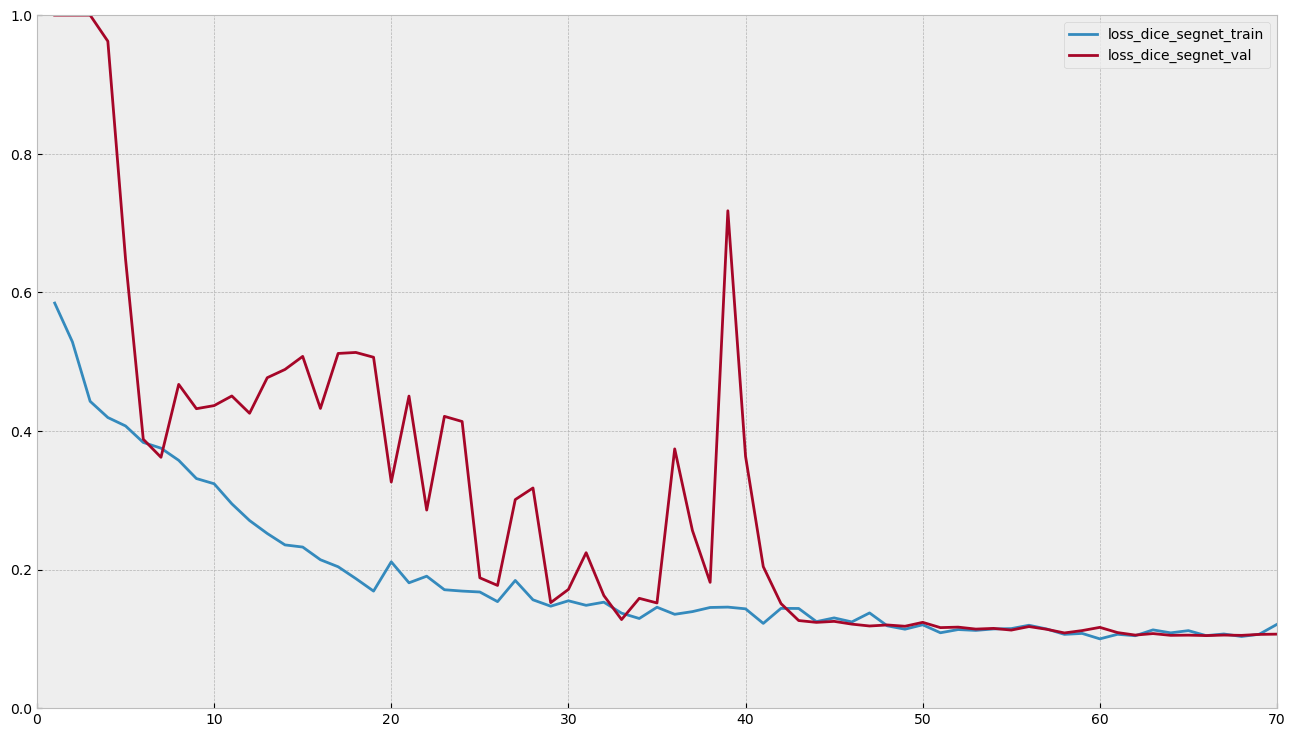

In [29]:
plot_loss(train_loss = dice_train_loss, val_loss = dice_val_loss, name = 'dice_segnet')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [30]:
def focal_loss( y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    return - torch.mean((eps + (1 - y_pred) ** gamma) * y_real * (torch.log(y_pred+ eps) ) + (1 - y_real) * (torch.log(1 - y_pred + eps)))


In [31]:
model_focal = SegNet().to(device)
max_epochs = 70
optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.05, weight_decay=0.05)
focal_train_loss, focal_val_loss, focal_segnet_iou = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.497869
val loss: 12.515561
val iou: 0.080000
* Epoch 2/70
loss: 0.421504
val loss: 12.515562
val iou: 0.080000
* Epoch 3/70
loss: 0.375901
val loss: 12.515558
val iou: 0.080000
* Epoch 4/70
loss: 0.353526
val loss: 12.504618
val iou: 0.080000
* Epoch 5/70
loss: 0.293324
val loss: 11.342232
val iou: 0.080000
* Epoch 6/70
loss: 0.255981
val loss: 5.550421
val iou: 0.080000
* Epoch 7/70
loss: 0.230111
val loss: 3.650790
val iou: 0.078000
* Epoch 8/70
loss: 0.210904
val loss: 3.583530
val iou: 0.078000
* Epoch 9/70
loss: 0.209231
val loss: 1.341537
val iou: 0.088000
* Epoch 10/70
loss: 0.196166
val loss: 0.864215
val iou: 0.102000
* Epoch 11/70
loss: 0.222132
val loss: 0.523028
val iou: 0.172000
* Epoch 12/70
loss: 0.209755
val loss: 0.254374
val iou: 0.456000
* Epoch 13/70
loss: 0.179276
val loss: 0.187231
val iou: 0.492000
* Epoch 14/70
loss: 0.177254
val loss: 0.174903
val iou: 0.372000
* Epoch 15/70
loss: 0.172882
val loss: 0.259123
val iou: 0.006000
* Epoch 16/70


In [32]:
focal_tr = score_model(model_focal, iou_pytorch, data_tr)
focal_val = score_model(model_focal, iou_pytorch, data_val)
focal_segnet_ts = score_model(model_focal, iou_pytorch, data_ts)
print(f'Метрика iou, loss focal segnet, train: {focal_tr}, val: {focal_val}, test: {focal_segnet_ts}')

Метрика iou, loss focal segnet, train: 0.6369999945163727, val: 0.5840000212192535, test: 0.585999995470047


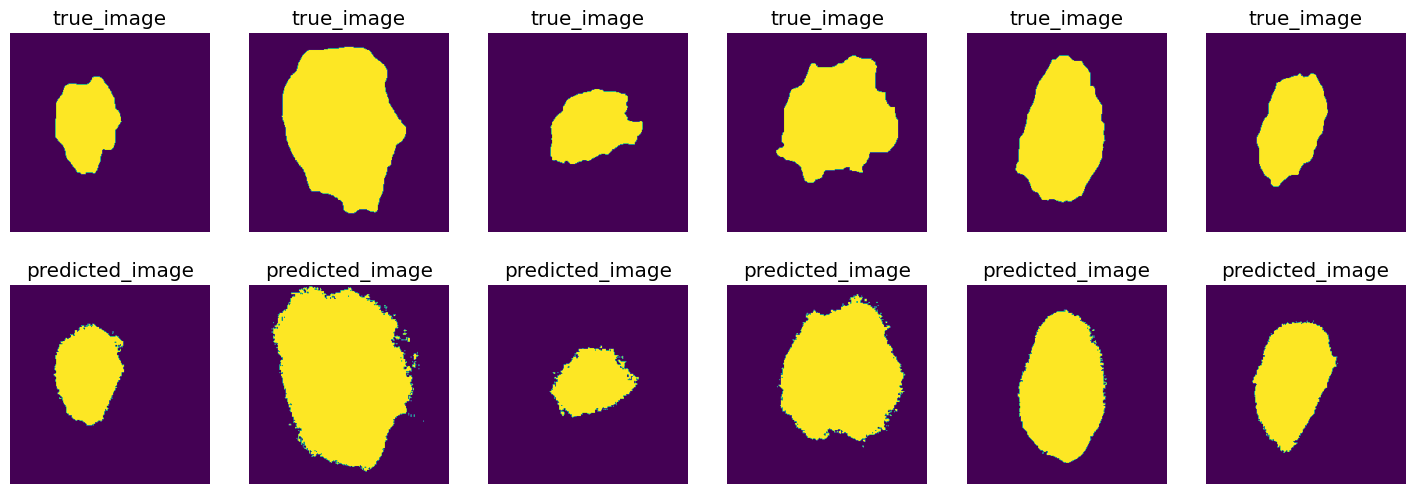

In [33]:
test_images(model_focal)

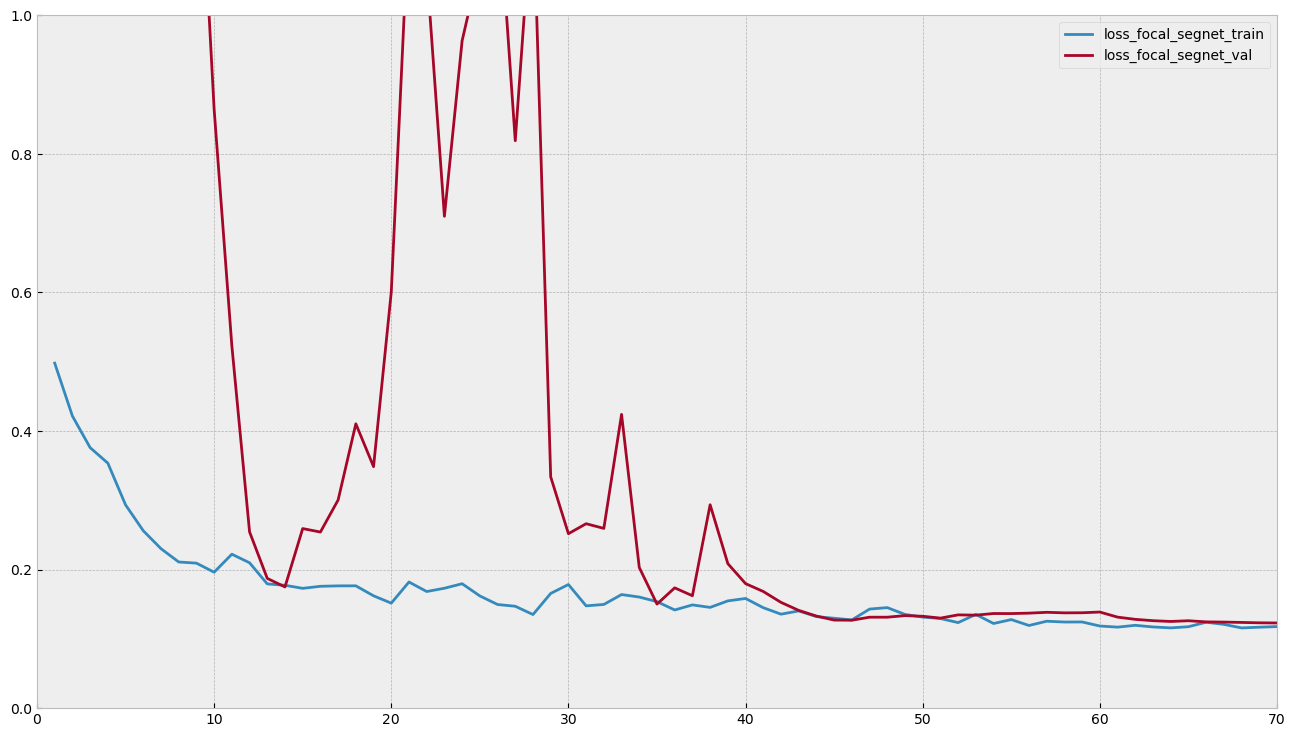

In [34]:
plot_loss(train_loss = focal_train_loss, val_loss = focal_val_loss, name = 'focal_segnet')

BCE но с Soft Targets----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [35]:
def tversky_loss( y_pred, y_real, eps = 1e-8, alpha = 0.5, beta= 0.5):
    y_pred = torch.sigmoid(y_pred)
    numerator = torch.sum(y_pred * y_real)
    denominator = numerator + alpha * torch.sum(y_pred * (1 - y_real)) + beta * torch.sum((1 - y_pred) * y_real)
    tversky = (numerator + eps) / (denominator + eps)
    return 1 - tversky

In [36]:
model_tversky = SegNet().to(device)
max_epochs = 70
optimizer = torch.optim.AdamW(model_tversky.parameters(), lr=0.05, weight_decay=0.05)
tversky_train_loss, tversky_val_loss, tversky_segnet_iou = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.589975
val loss: 0.515712
val iou: 0.080000
* Epoch 2/70
loss: 0.526773
val loss: 0.518724
val iou: 0.080000
* Epoch 3/70
loss: 0.450616
val loss: 0.514956
val iou: 0.080000
* Epoch 4/70
loss: 0.411616
val loss: 0.514718
val iou: 0.080000
* Epoch 5/70
loss: 0.372088
val loss: 0.519176
val iou: 0.080000
* Epoch 6/70
loss: 0.344043
val loss: 0.506242
val iou: 0.080000
* Epoch 7/70
loss: 0.323121
val loss: 0.465127
val iou: 0.088000
* Epoch 8/70
loss: 0.277894
val loss: 0.483995
val iou: 0.084000
* Epoch 9/70
loss: 0.250457
val loss: 0.415506
val iou: 0.126000
* Epoch 10/70
loss: 0.242405
val loss: 0.210314
val iou: 0.554000
* Epoch 11/70
loss: 0.220608
val loss: 0.198600
val iou: 0.528000
* Epoch 12/70
loss: 0.208064
val loss: 0.211607
val iou: 0.506000
* Epoch 13/70
loss: 0.202955
val loss: 0.203517
val iou: 0.508000
* Epoch 14/70
loss: 0.234966
val loss: 0.181127
val iou: 0.552000
* Epoch 15/70
loss: 0.180052
val loss: 0.261525
val iou: 0.402000
* Epoch 16/70
loss:

In [37]:
tversky_tr = score_model(model_tversky, iou_pytorch, data_tr)
tversky_val = score_model(model_tversky, iou_pytorch, data_val)
tversky_segnet_ts = score_model(model_tversky, iou_pytorch, data_ts)
print(f'Метрика iou, loss focal: train: {tversky_tr}, val: {tversky_val}, test: {tversky_segnet_ts}')

Метрика iou, loss focal: train: 0.7089999914169312, val: 0.6480000019073486, test: 0.6619999408721924


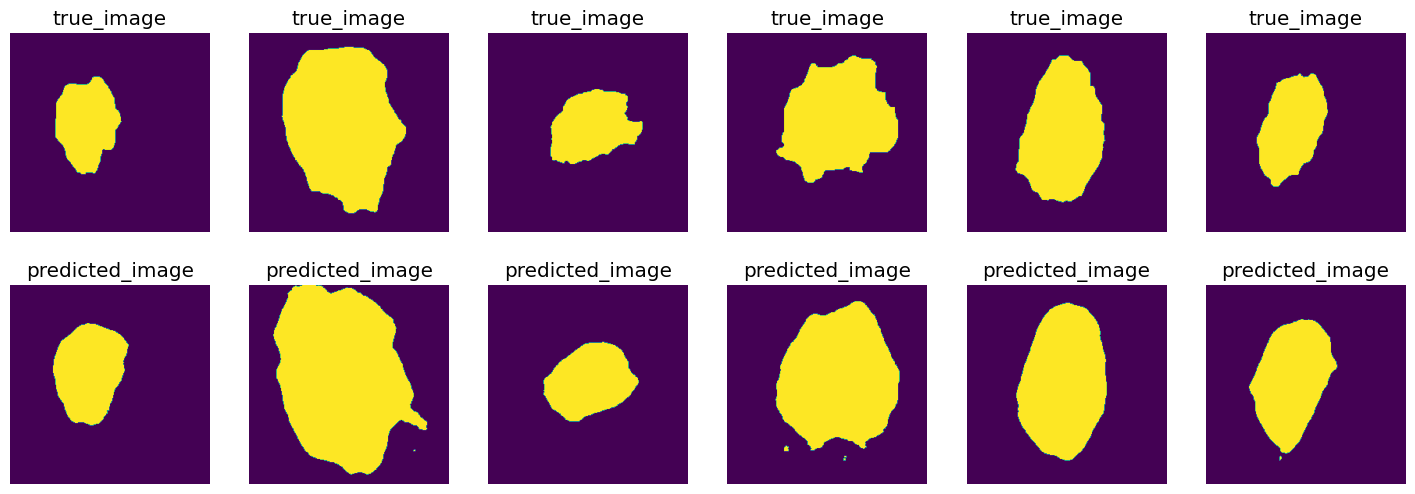

In [38]:
test_images(model_tversky)

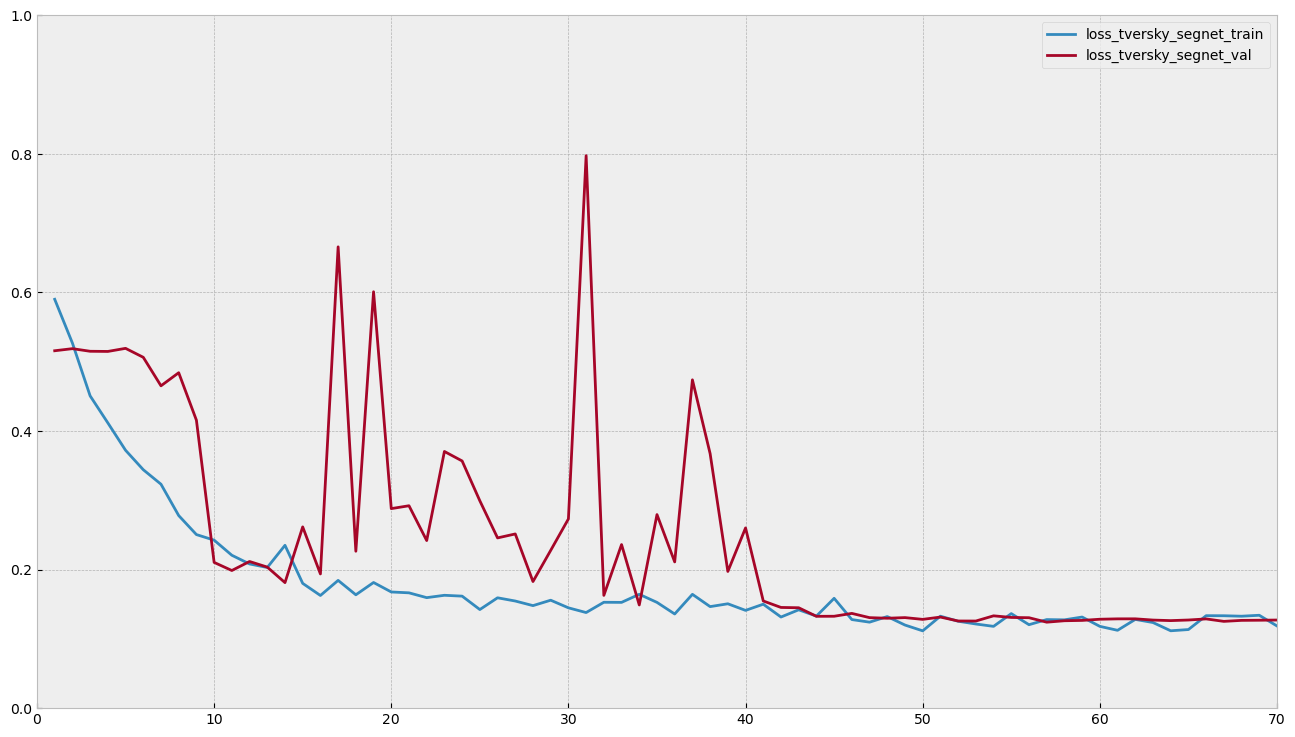

In [39]:
plot_loss(train_loss = tversky_train_loss, val_loss = tversky_val_loss, name = 'tversky_segnet')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

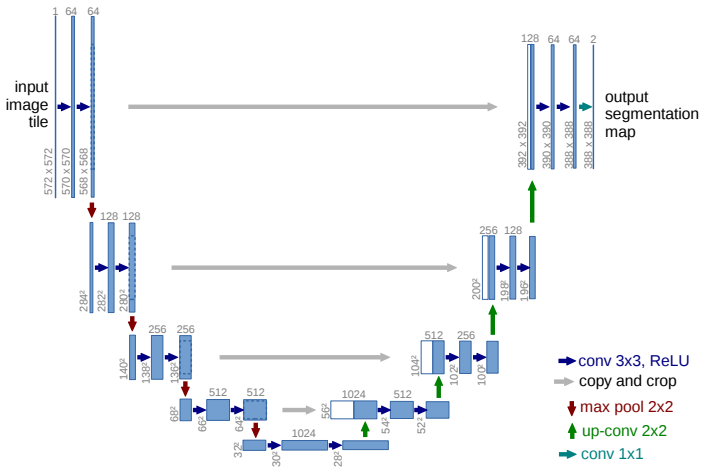

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [40]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True) # 32 -> 16
        
        self.bottle_neck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0),
            nn.BatchNorm2d(1024), 
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )
        
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )                          
    
    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(c0)
        size1 = e0.size()
        c1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(c1)
        size2 = e1.size()
        c2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(c2)
        size3 = e2.size()
        c3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(c3)
        # bottleneck
        b = self.bottle_neck_conv(e3)
        # decoder
        d1 = self.dec_conv1(torch.cat([self.upsample1(b, ind3, output_size=size3), c3],dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, ind2, output_size=size2), c2], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, ind1, output_size=size1), c1], dim=1))
        d4 = self.dec_conv4(torch.cat([self.upsample4(d3, ind0), c0], dim=1))
        return d4

In [41]:
model_UNet_Bce = UNet().to(device)
max_epochs = 70
optimizer = torch.optim.AdamW(model_UNet_Bce.parameters(), lr=0.05, weight_decay=0.05)
UNet_Bce_train_loss, UNet_Bce_val_loss, bce_unet_iou = train(model_UNet_Bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.598707
val loss: inf
val iou: 0.000000
* Epoch 2/70
loss: 0.493717
val loss: inf
val iou: 0.000000
* Epoch 3/70
loss: 0.451395
val loss: inf
val iou: 0.000000
* Epoch 4/70
loss: 0.407002
val loss: inf
val iou: 0.024000
* Epoch 5/70
loss: 0.357295
val loss: 0.405215
val iou: 0.210000
* Epoch 6/70
loss: 0.327830
val loss: 0.452369
val iou: 0.310000
* Epoch 7/70
loss: 0.295708
val loss: 0.281267
val iou: 0.432000
* Epoch 8/70
loss: 0.284038
val loss: 0.317657
val iou: 0.408000
* Epoch 9/70
loss: 0.283810
val loss: 0.281745
val iou: 0.502000
* Epoch 10/70
loss: 0.260021
val loss: 0.382820
val iou: 0.458000
* Epoch 11/70
loss: 0.248434
val loss: 0.283131
val iou: 0.564000
* Epoch 12/70
loss: 0.264453
val loss: 0.240418
val iou: 0.582000
* Epoch 13/70
loss: 0.247814
val loss: 0.273522
val iou: 0.556000
* Epoch 14/70
loss: 0.227541
val loss: 0.281449
val iou: 0.522000
* Epoch 15/70
loss: 0.253007
val loss: 0.320788
val iou: 0.356000
* Epoch 16/70
loss: 0.237639
val loss: 

In [42]:
UNet_Bce_tr = score_model(model_UNet_Bce, iou_pytorch, data_tr)
UNet_Bce_val = score_model(model_UNet_Bce, iou_pytorch, data_val)
bce_unet_ts = score_model(model_UNet_Bce, iou_pytorch, data_ts)
print(f'Метрика iou, UNet_Bce: train: {UNet_Bce_tr}, val: {UNet_Bce_val}, test: {bce_unet_ts}')

Метрика iou, UNet_Bce: train: 0.7609999626874924, val: 0.7419999837875366, test: 0.7059999704360962


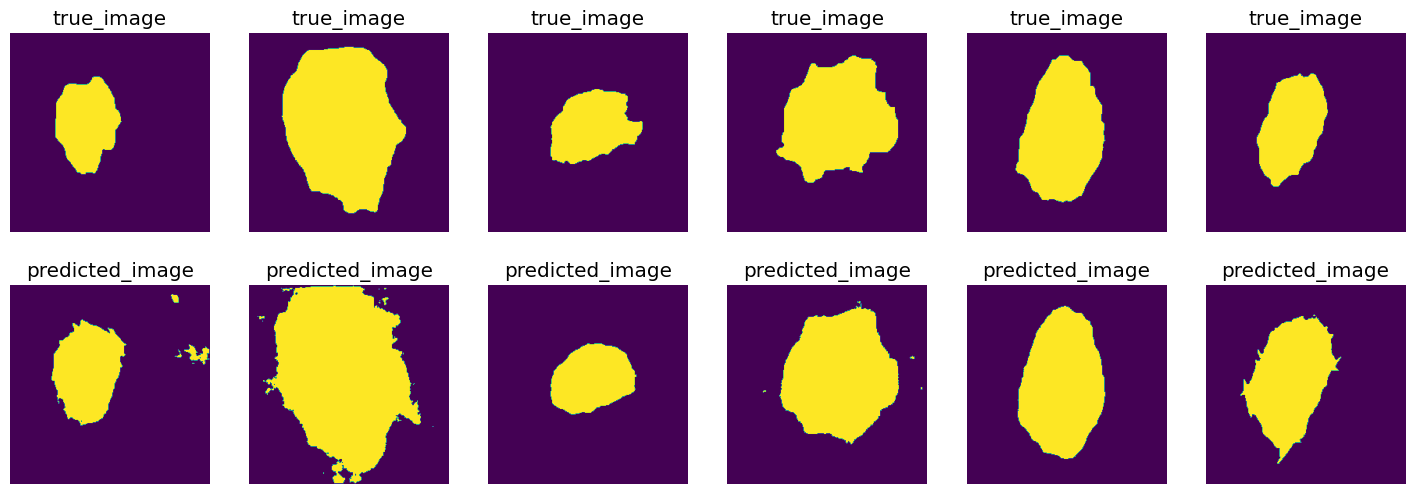

In [43]:
test_images(model_UNet_Bce)

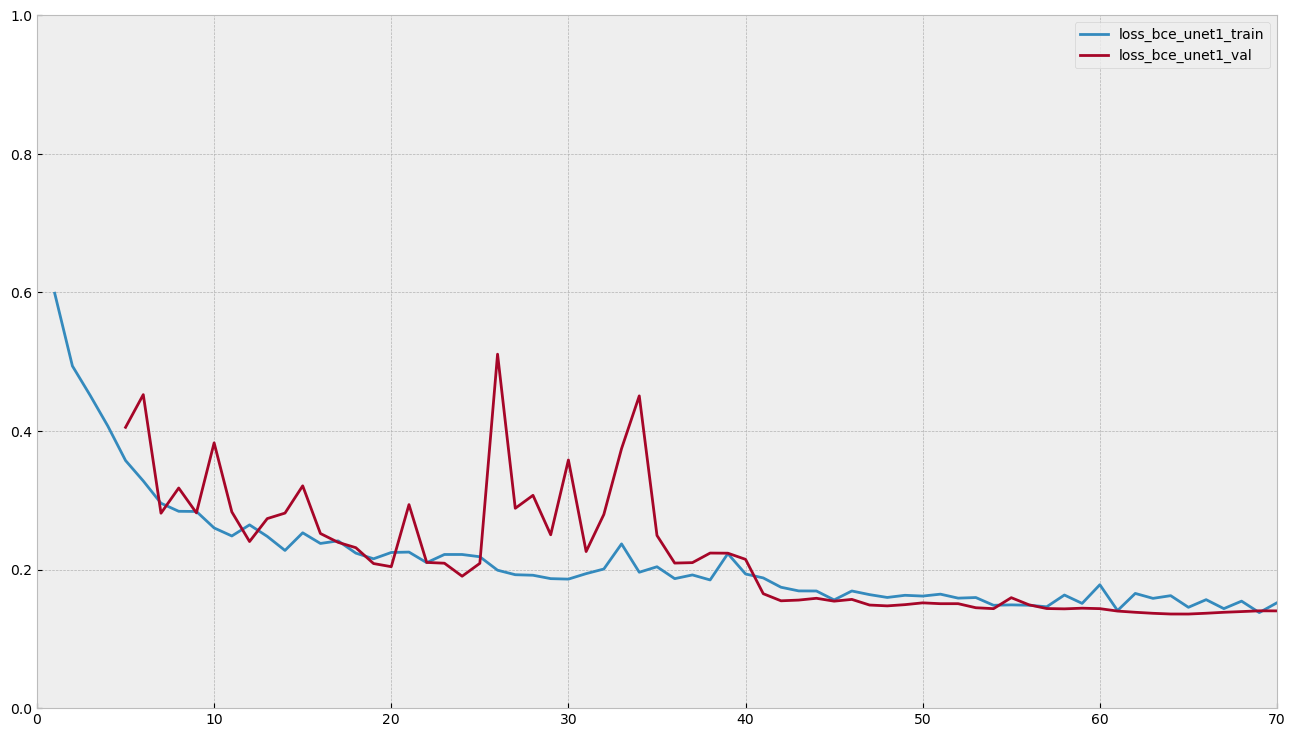

In [44]:
plot_loss(train_loss = UNet_Bce_train_loss, val_loss = UNet_Bce_val_loss, name = 'bce_unet1')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [45]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16
        
        self.bottle_neck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0),
            nn.BatchNorm2d(1024), 
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512), 
            nn.ReLU()
        )
        
        self.upsample1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.upsample4 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1)  # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )                          
    
    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        size0 = c0.size()
        e0 = self.pool0(c0)
        size1 = e0.size()
        c1 = self.enc_conv1(e0)
        e1 = self.pool1(c1)
        size2 = e1.size()
        c2 = self.enc_conv2(e1)
        e2 = self.pool2(c2)
        size3 = e2.size()
        c3 = self.enc_conv3(e2)
        e3 = self.pool3(c3)
        # bottleneck
        b = self.bottle_neck_conv(e3)
        # decoder
        d1 = self.dec_conv1(torch.cat([self.upsample1(b, output_size=size3), c3],dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, output_size=size2), c2], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, output_size=size1), c1], dim=1))
        d4 = self.dec_conv4(torch.cat([self.upsample4(d3, output_size=size0), c0], dim=1))
        return d4


In [46]:
model_UNet2_Bce = UNet2().to(device)
max_epochs = 70
optimizer = torch.optim.AdamW(model_UNet2_Bce.parameters(), lr=0.05, weight_decay=0.05)
UNet2_Bce_train_loss, UNet2_Bce_val_loss, bce_unet2_iou = train(model_UNet2_Bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/70
loss: 0.709417
val loss: 999439335424.000000
val iou: 0.080000
* Epoch 2/70
loss: 0.531087
val loss: 16233236.000000
val iou: 0.080000
* Epoch 3/70
loss: 0.455902
val loss: 57966.898438
val iou: 0.080000
* Epoch 4/70
loss: 0.431009
val loss: 669.937012
val iou: 0.080000
* Epoch 5/70
loss: 0.383360
val loss: 17.709942
val iou: 0.080000
* Epoch 6/70
loss: 0.346463
val loss: 8.308265
val iou: 0.104000
* Epoch 7/70
loss: 0.312807
val loss: 2.617427
val iou: 0.136000
* Epoch 8/70
loss: 0.309170
val loss: 2.263788
val iou: 0.078000
* Epoch 9/70
loss: 0.311710
val loss: 2.089950
val iou: 0.096000
* Epoch 10/70
loss: 0.286573
val loss: 0.928959
val iou: 0.104000
* Epoch 11/70
loss: 0.261384
val loss: 0.696705
val iou: 0.216000
* Epoch 12/70
loss: 0.268221
val loss: 0.308526
val iou: 0.498000
* Epoch 13/70
loss: 0.279293
val loss: 0.341189
val iou: 0.480000
* Epoch 14/70
loss: 0.259835
val loss: 0.250762
val iou: 0.568000
* Epoch 15/70
loss: 0.241683
val loss: 0.303129
val iou: 0.5

In [47]:
UNet2_Bce_tr = score_model(model_UNet2_Bce, iou_pytorch, data_tr)
UNet2_Bce_val = score_model(model_UNet2_Bce, iou_pytorch, data_val)
bce_unet2_ts = score_model(model_UNet2_Bce, iou_pytorch, data_ts)
print(f'Метрика iou, UNet_Bce: train: {UNet2_Bce_tr}, val: {UNet2_Bce_val}, test: {bce_unet2_ts}')

Метрика iou, UNet_Bce: train: 0.7059999853372574, val: 0.6820000112056732, test: 0.6559999585151672


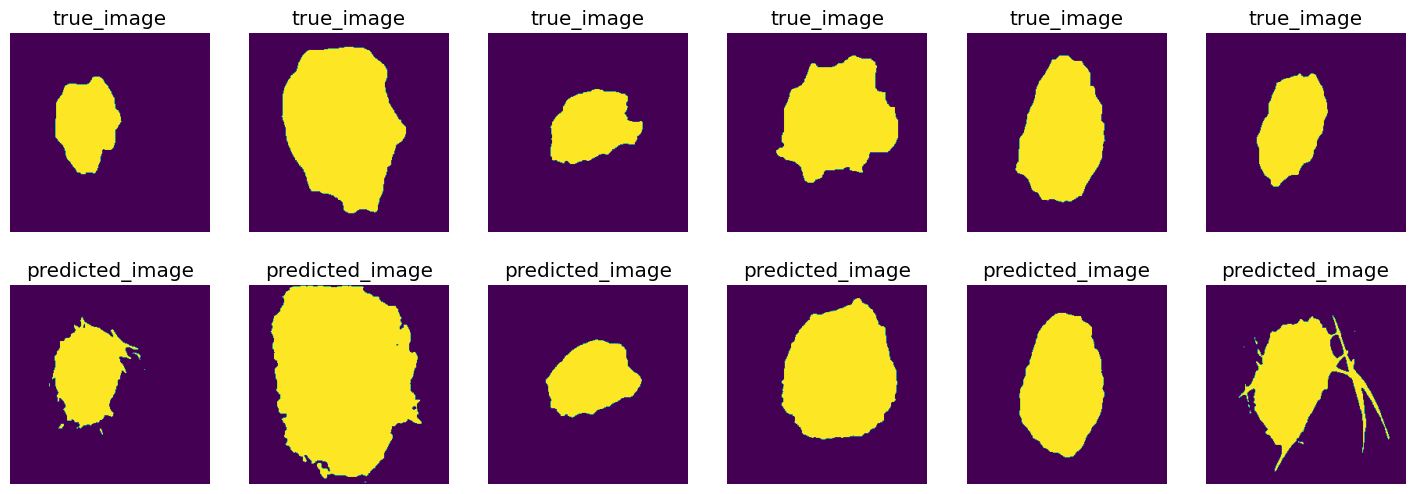

In [48]:
test_images(model_UNet2_Bce)

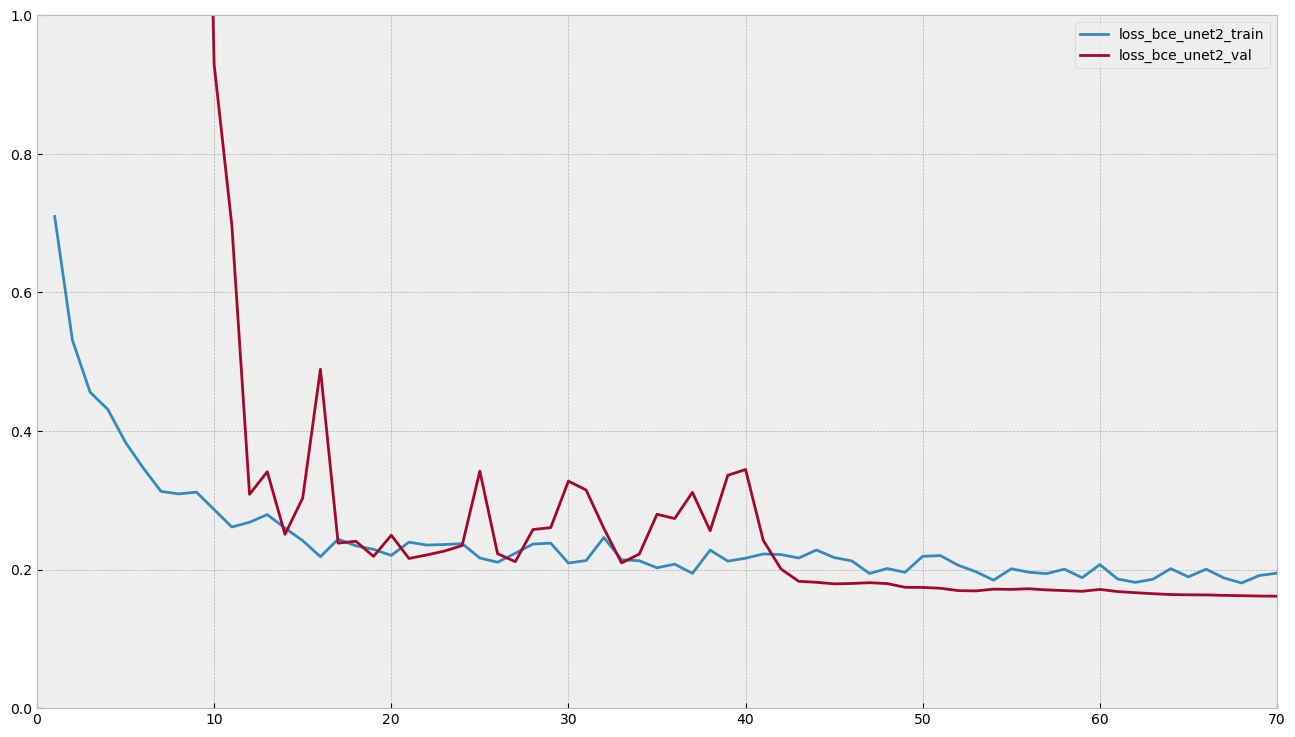

In [49]:
plot_loss(train_loss = UNet2_Bce_train_loss, val_loss = UNet2_Bce_val_loss, name = 'bce_unet2')

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [50]:
'''
Я считаю, что в качестве окончательного отчета стоит сравнить все обученные выше модели между собой при помощи iou на валидационных и тестовых данных.
Использование разных лоссов для UNet только загромоздит и без того большой ноутбук. С самого начала в ноутбуке присутствуют некоторые элементы анализа
моделей (графики лоссов, сравнения генерируемых изображений, итоговые метрики). В конце приводится графическая сводка проделанной работы.
'''
dict_val_score = {'bce_segnet': bce_segnet_iou,'dice_segnet': dice_segnet_iou, 'focal_segnet': focal_segnet_iou, 
                  'tversky_segnet': tversky_segnet_iou, 'bce_unet': bce_unet_iou, 'bce_unet2': bce_unet2_iou}
dict_test_score = {'bce_segnet': bce_segnet_ts,'dice_segnet': dice_segnet_ts, 'focal_segnet': focal_segnet_ts, 
                  'tversky_segnet': tversky_segnet_ts, 'bce_unet': bce_unet_ts, 'bce_unet2': bce_unet_ts}

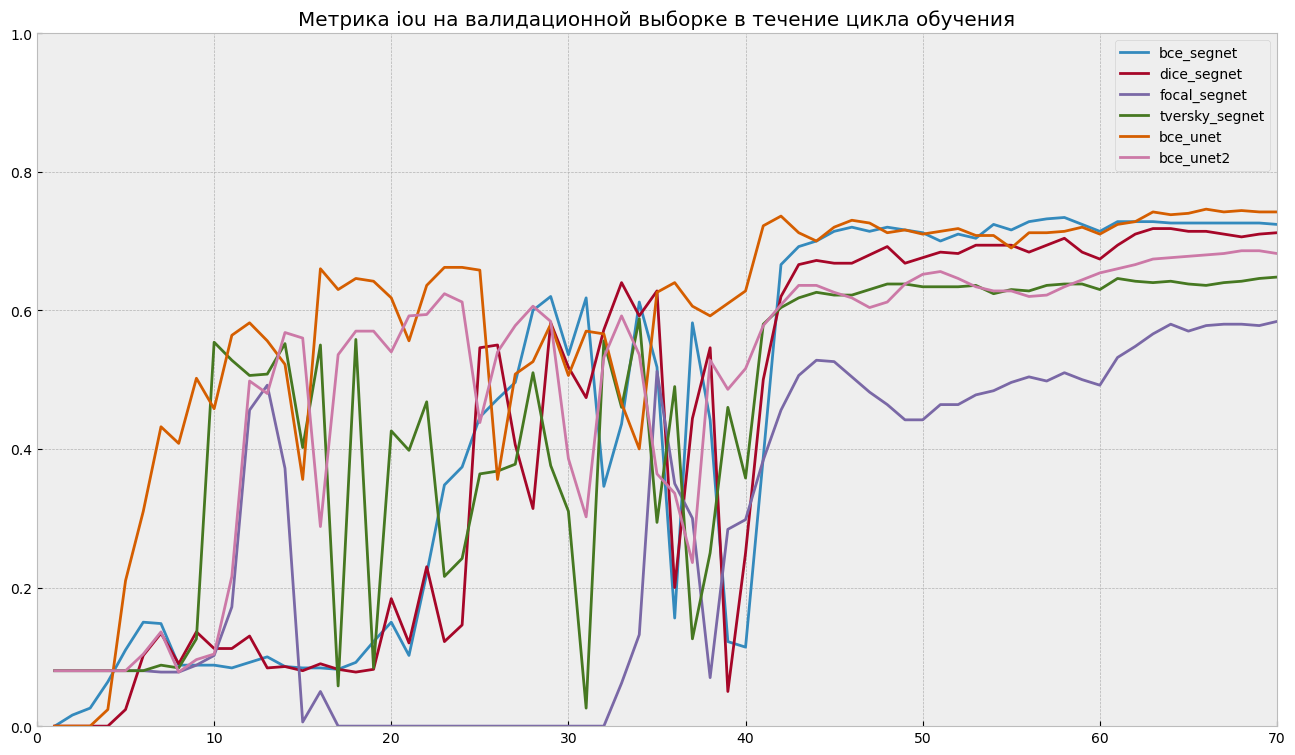

In [51]:
epochs = np.arange(1, 71, 1)
plt.style. use('bmh')
plt.figure(figsize = (16, 9))
plt.ylim([0,1])
plt.xlim([0,70])
plt.title('Метрика iou на валидационной выборке в течение цикла обучения')
for key in dict_val_score:
    plt.plot(epochs, dict_val_score[key], label=key)
plt.legend()

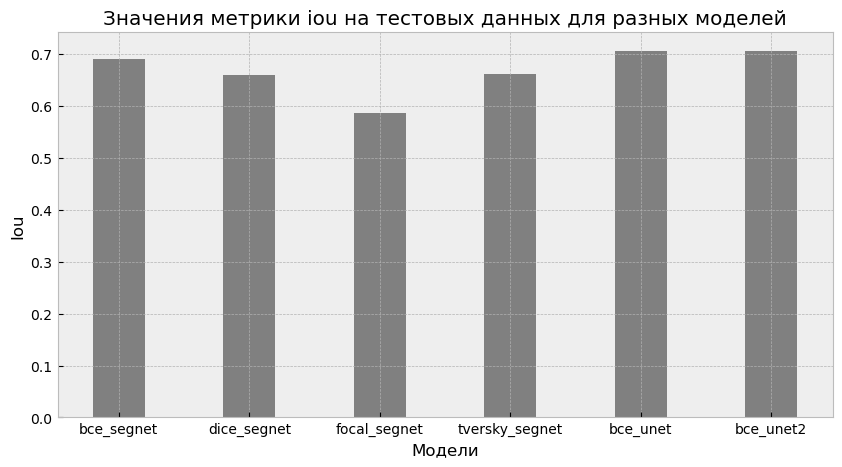

In [53]:
models = list(dict_test_score.keys())
values = list(dict_test_score.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, values, color ='grey',
        width = 0.4)
plt.xlabel("Модели")
plt.ylabel("Iou")
plt.title("Значения метрики iou на тестовых данных для разных моделей");

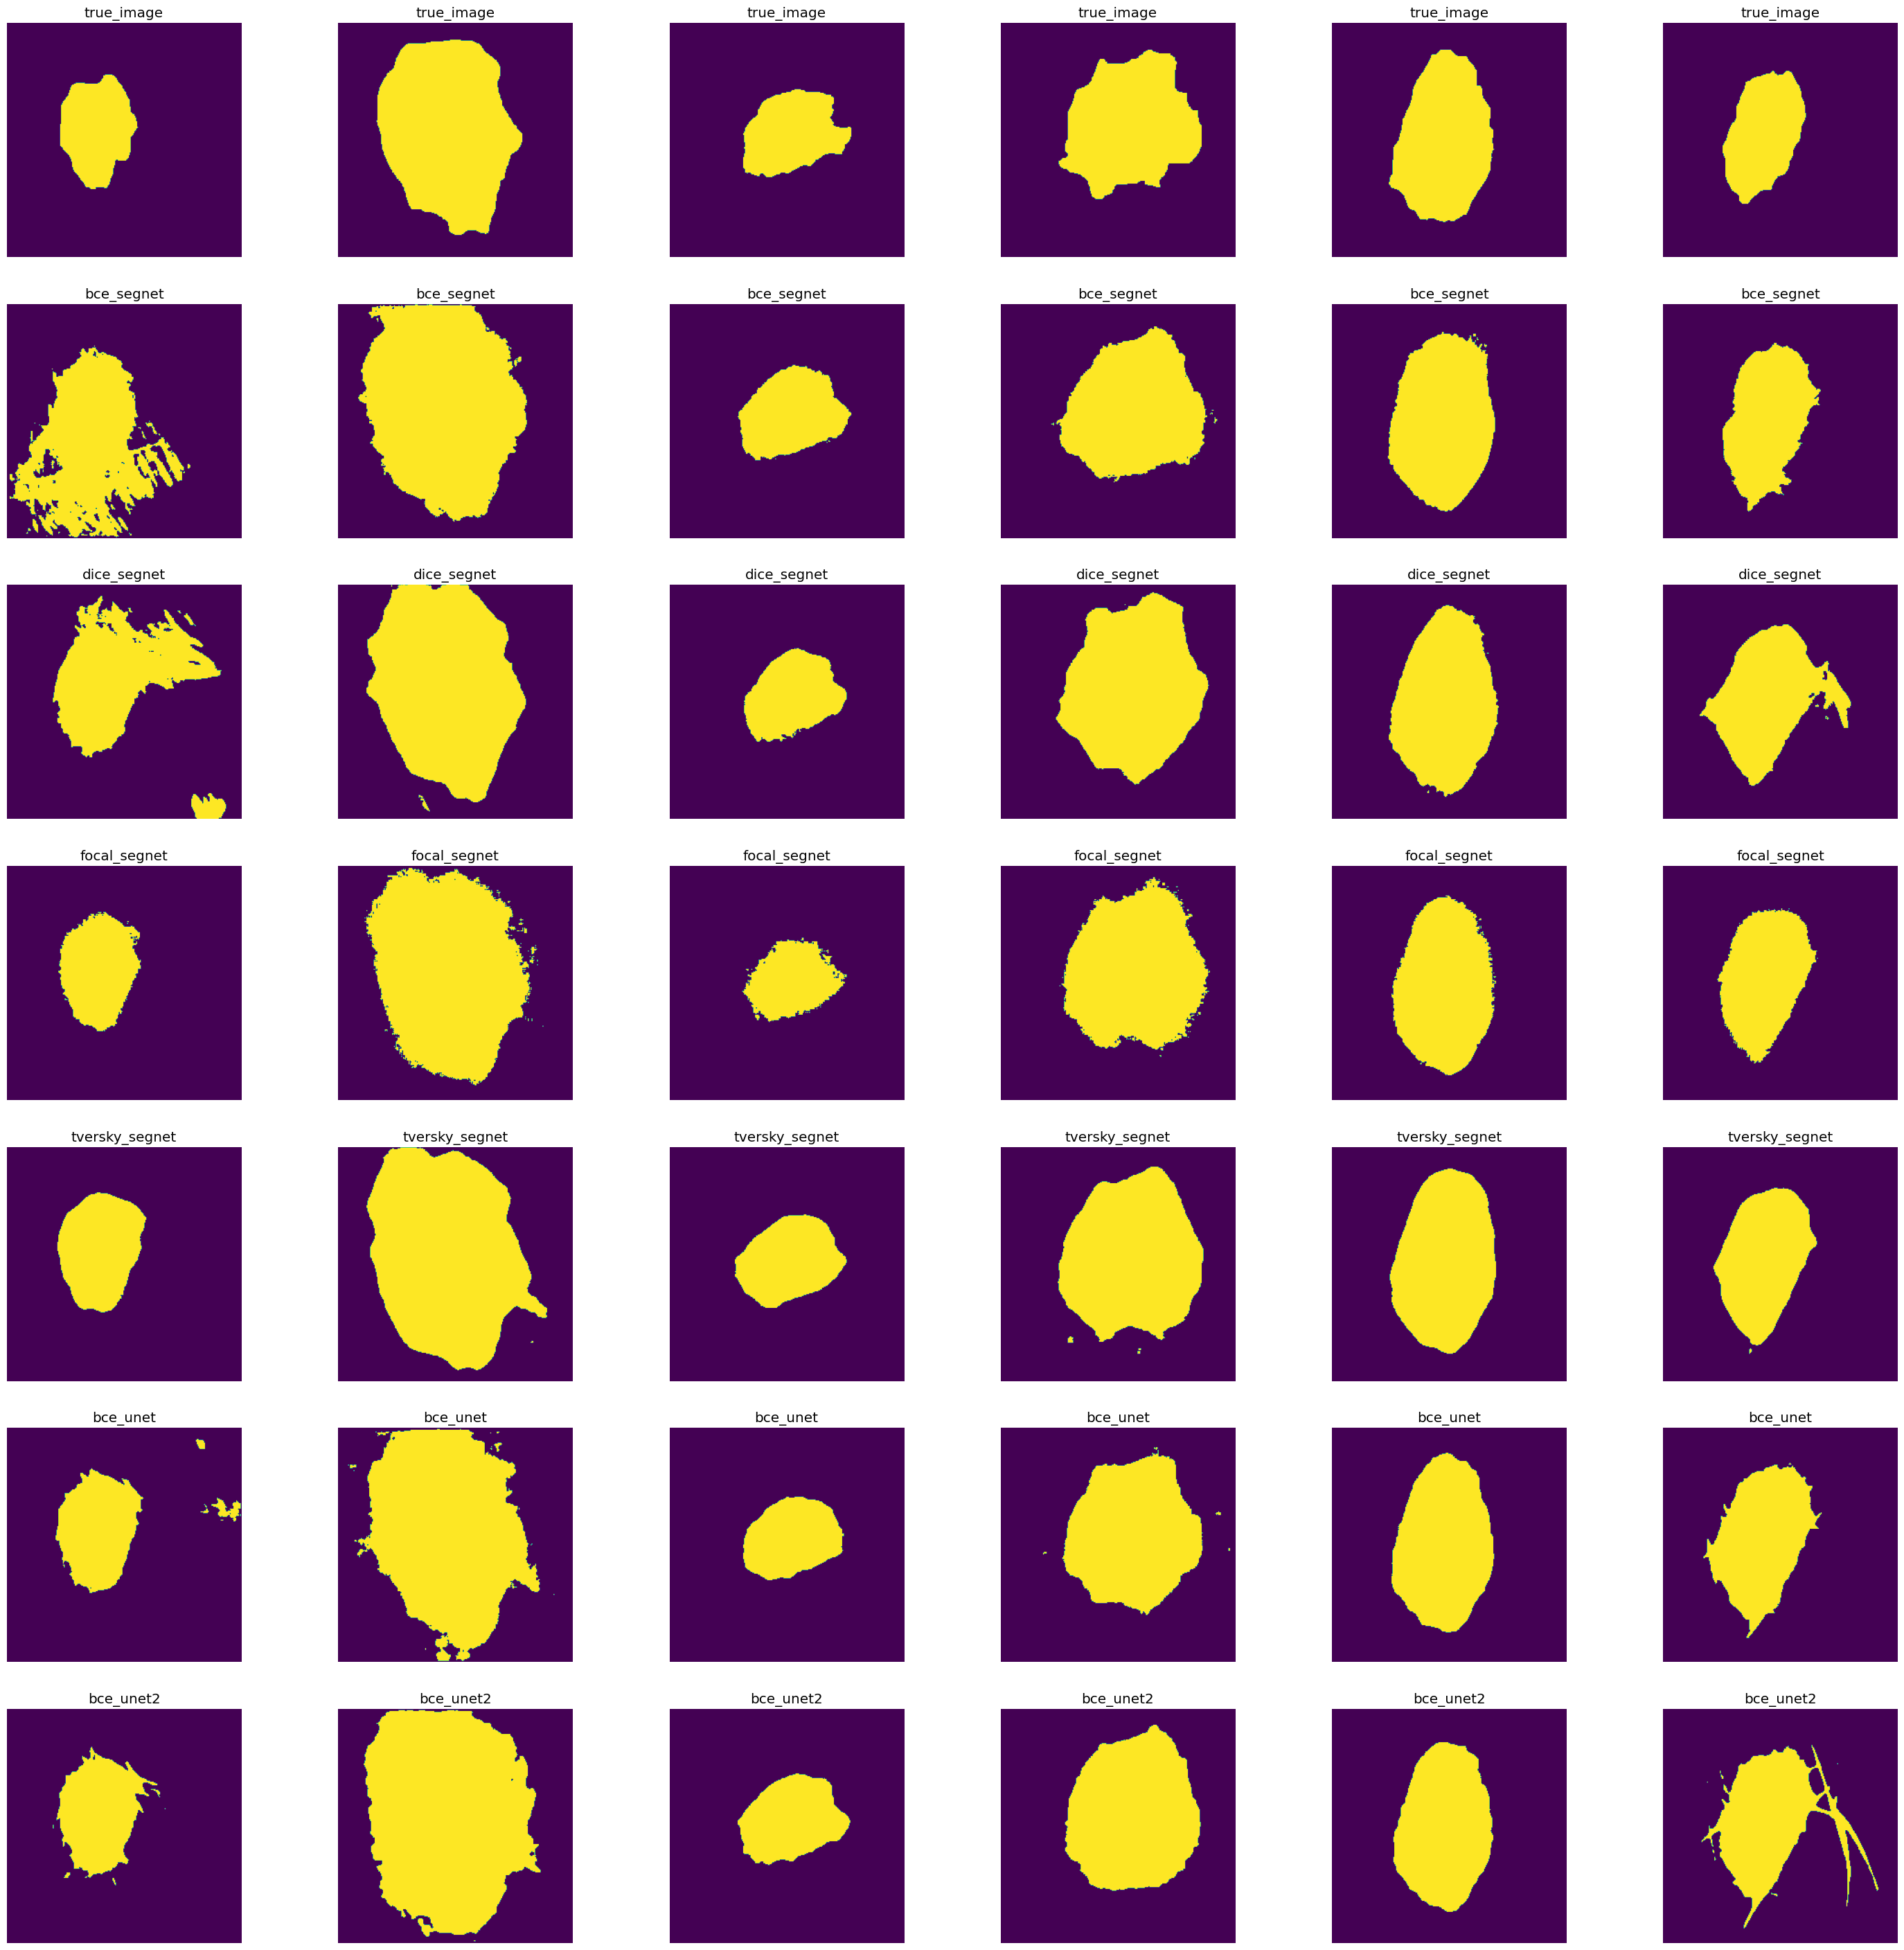

In [66]:
#Первые шесть тестовых изображений для визуального сравнения качества разных моделей
dict_models = {'bce_segnet': model,'dice_segnet': model_dice, 'focal_segnet': model_focal, 
                  'tversky_segnet': model_tversky, 'bce_unet': model_UNet_Bce, 'bce_unet2': model_UNet2_Bce}
test_true = np.array([Y_batch.numpy() for _, Y_batch in data_ts], dtype='float32').reshape(50, 256, 256)
plt.figure(figsize=(36, 36))
number = list(range(1,7))
for i in range(6):
    plt.subplot(7, 6, i+1)
    plt.axis("off")
    plt.title('true_image')
    plt.imshow(test_true[i])
    
    for j, key in zip(number, dict_models):
        plt.subplot(7, 6, i + 6 * j + 1)
        plt.axis("off")
        plt.title(key)
        plt.imshow(predict(dict_models[key], data_ts).reshape(50, 256, 256)[i])
plt.show();

По итогу можно сделать вывод, что модель unet дает несколько лучшее качество по метрике iou, благодаря дополнительной пространственной информации.
А также при просмотре разных лоссов на модели segnet видно, что в данном случае наилучшее качество дает loss bce (однако все может измениться, если при обучении будет достигнут менее удачнй локальный минимум). 